In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import random
from PIL import Image
import cv2
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install evaluate jiwer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 607.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: levenshtein
    Found existing installation: Levenshtein 0.20.7
    Uninstalling Levenshtein-0.20.7:
      Successfully uninstalled Levenshtein-0.20.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-levenshtein 0.20.7 requires Levenshtein==0.20.7, but you have levenshtein 0.20.2 which is incompatible.


In [3]:
"""Seed everything!"""
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
device

#  **Load dataset**

### Tokenize car numbers

In [4]:
# Get the list of car numbers
def exec_text(path):
    return path[path.find('-') + 1:path.find('.')]

input_dir_train = '/kaggle/input/labtinkoff/CCPD2019-dl1/train'

car_numbers = [exec_text(path) for  path in os.listdir(input_dir_train)]

In [5]:
# Get the alphabet of symbols from all car numbers
seq = ''
for car_number in car_numbers:
    seq += car_number
alphabet = ''
for symbol in sorted(set(seq)):
    alphabet += symbol
alphabet    

'0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ云京冀吉宁川新晋桂沪津浙渝湘琼甘皖粤苏蒙藏豫贵赣辽鄂闽陕青鲁黑'

In [6]:
OOV_TOKEN = '<OOV>' # out of vocabulary token
CTC_BLANK = '<BLANK>' # token for ctc matrix
PAD_TOKEN = '<PAD>' # padding token


def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char for CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 3 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    char_map[PAD_TOKEN] = 2
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

In [7]:
tokenizer = Tokenizer(alphabet)

In [8]:
class Laba_dataset(torch.utils.data.Dataset):
    def __init__(self, root, tokenizer, transform=None):
        self.root = root
        self.transform = transform
        self.tokenizer = tokenizer
        self.img_paths = [os.path.join(self.root, img_path) for img_path in os.listdir(self.root)]
        self.text = [exec_text(path) for path in os.listdir(self.root)]
        self.enc_text = self.tokenizer.encode(self.text)
    
    def __getitem__(self, ind):
        img = Image.open(self.img_paths[ind]) # resize
        if self.transform is not None:
            img = self.transform(img) # make some augmentations
        # return image, encoded_text, source_text
        return (img, torch.LongTensor(self.enc_text[ind]), self.text[ind])

    def __len__(self):
        return len(self.img_paths)

In [9]:
def collate_fn(batch):
    images, enc_texts, texts = zip(*batch)
    images = torch.stack(images, 0)
    enc_pad_texts = torch.nn.utils.rnn.pad_sequence(enc_texts, batch_first=True, padding_value=tokenizer.char_map[PAD_TOKEN])
    return images, enc_pad_texts, texts

In [10]:
from sklearn.model_selection import train_test_split
batch_size = 128
# some augmentetions for model regularization
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 128)),
    torchvision.transforms.RandomRotation(5),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.GaussianBlur(3),
    torchvision.transforms.ToTensor()
        ])
dataset_full = Laba_dataset(input_dir_train, tokenizer, transform=transform)
# split full dataset
train_idx, valid_idx = train_test_split(list(range(len(dataset_full))), train_size=0.9)
dataset = {
    'train': torch.utils.data.Subset(dataset_full, train_idx),
    'valid': torch.utils.data.Subset(dataset_full, valid_idx)
}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset['valid'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    ),
}

In [11]:
input_dir_test = '/kaggle/input/labtinkoff/CCPD2019-dl1/test'
batch_size = 64
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 128)),
    torchvision.transforms.ToTensor()
        ])
dataset_test = Laba_dataset(input_dir_test, tokenizer, transform=transform_test)
dataloader_test = torch.utils.data.DataLoader(
        dataset=dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    )

In [12]:
next(iter(dataloader['train']))[0].shape

torch.Size([128, 3, 32, 128])

In [13]:
img = torchvision.transforms.ToPILImage()(dataset_full[173][0].squeeze(0)) # take a look to random image

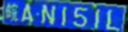

In [14]:
img

In [15]:
dataset_test[122] # take a look to element from dataset

(tensor([[[0.5451, 0.5529, 0.5608,  ..., 0.4157, 0.4118, 0.4706],
          [0.4431, 0.4039, 0.4039,  ..., 0.4157, 0.5020, 0.5647],
          [0.3333, 0.2980, 0.3059,  ..., 0.2353, 0.3137, 0.4353],
          ...,
          [0.3333, 0.3137, 0.2667,  ..., 0.1608, 0.1490, 0.1843],
          [0.3216, 0.3176, 0.3098,  ..., 0.4471, 0.4706, 0.5020],
          [0.3255, 0.3333, 0.3529,  ..., 0.3922, 0.4314, 0.4471]],
 
         [[0.5059, 0.5059, 0.5059,  ..., 0.4745, 0.4706, 0.5373],
          [0.4275, 0.3686, 0.3608,  ..., 0.5216, 0.6000, 0.6627],
          [0.3569, 0.3020, 0.2980,  ..., 0.3804, 0.4431, 0.5490],
          ...,
          [0.4431, 0.4235, 0.3725,  ..., 0.2353, 0.2392, 0.2824],
          [0.4157, 0.4157, 0.4078,  ..., 0.5255, 0.5647, 0.6000],
          [0.4157, 0.4235, 0.4431,  ..., 0.4784, 0.5255, 0.5412]],
 
         [[0.6275, 0.6353, 0.6431,  ..., 0.5451, 0.5176, 0.5333],
          [0.5961, 0.5765, 0.6000,  ..., 0.6000, 0.6353, 0.6471],
          [0.5490, 0.5725, 0.6471,  ...,

## Define model

In [16]:
from torch import nn

To solve the problem i use CRNN structure

Approximate model structure and LSTM structure
*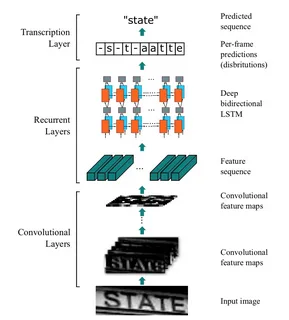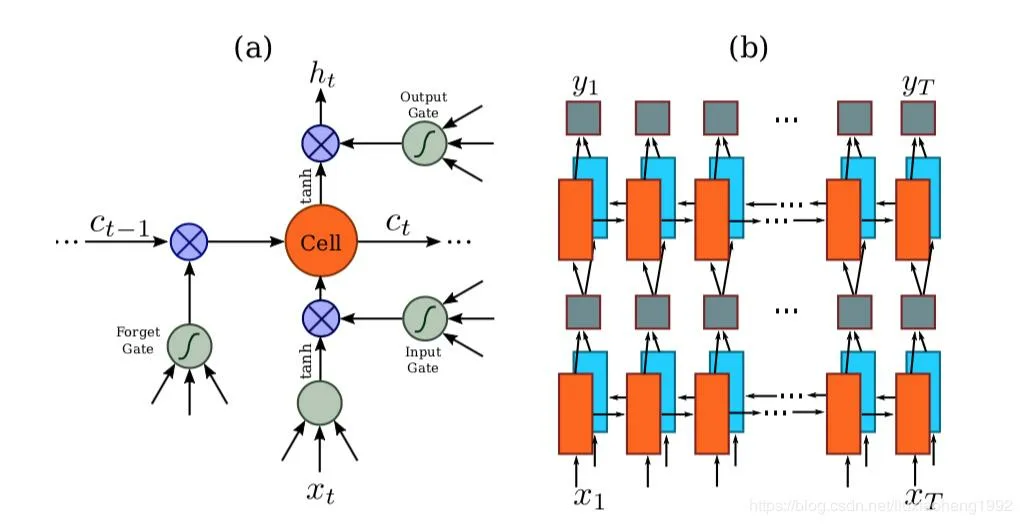*

In [17]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, dropout=0.15):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, 1, stride=2)
        
    def forward(self, x, identity=True):
        out = self.dropout(self.bn(self.conv(x)))
        if identity:
            if self.downsample is not None:
                x = self.downsample(x)
            return self.relu(out + x)
        else: 
            return self.relu(out)
    
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_layers=2, dropout=0.1):
        super().__init__()
        """
        As feature extractor i use resnet, passing through the cut the images are 
        transformed from the dimension tensor (C: 1, W: 128, H: 32) to the 
        dimension tensor (C: 1, W: 4, H: 1)
        """
        self.start = ResNetBlock(3, 64, 7, 1, 0, 0.0)
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.blocks1 = nn.ModuleList([ResNetBlock(64, 64, padding=1) for _ in range(num_layers)])
        self.blocks2 = nn.ModuleList([ResNetBlock(64, 128, padding=1, stride=2)] + [ResNetBlock(128, 128, padding=1) for _ in range(num_layers)])
        self.blocks3 = nn.ModuleList([ResNetBlock(128, 256, padding=1, stride=2)] + [ResNetBlock(256, 256, padding=1) for _ in range(num_layers)])
        self.blocks4 = nn.ModuleList([ResNetBlock(256, 512, padding=1, stride=2)] + [ResNetBlock(512, 512, padding=1) for _ in range(num_layers)])
        self.blocks5 = nn.ModuleList([ResNetBlock(512, 1024, padding=1, stride=2)] + [ResNetBlock(1024, 1024, padding=1) for _ in range(num_layers)])
        self.blocks = [self.blocks1, self.blocks2, self.blocks3, self.blocks4, self.blocks5]
        
    def forward(self, x):
        out = self.maxpool(self.start(x, identity=False))
        for blocks in self.blocks:
            for block in blocks:
                out = block(out)

        return out

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

"""
5 ResNet blocks, 3 BiLSTM, Linear Classifier
in order for the model to be able to identify more complex 
dependencies in the data, since the dataset allows you to enter
a deep neural network
""" 
class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
        lstm_len=3,
    ):
        super().__init__()
        self.feature_extractor = CNN(dropout=0.15)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len, dropout=0.15)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.Linear(time_feature_count, number_class_symbols) # the model predicts the probability of characters from the alphabet
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)

        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

### Define accuracy metric for evaluate validation dataset

In [18]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

# Training loop

In [19]:
# functions for saving models
import pickle as pkl

def safe(obj, filename):
    with open(filename, 'wb') as outp:
        pkl.dump(obj, outp)
        
def read(filename):
    with open(filename, 'rb') as inp:
        return pkl.load(inp)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [41]:
def val_loop(data_loader, model, tokenizer, device):
    acc_avg = AverageMeter()
    for images, enc_texts, texts in data_loader:
        batch_size = len(texts)
        text_preds = predict(images, model, tokenizer, device)
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
    print(f'Validation, acc: {acc_avg.avg:.4f}')
    return acc_avg.avg

def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds

def train_loop(data_loader, model, criterion, optimizer, epoch):
    loss_avg = AverageMeter()
    model.train()
    for images, enc_texts, texts in data_loader:
        model.zero_grad()
        images = images.to(device)
        batch_size = len(texts)
        output = model(images)
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )
        text_lens = torch.LongTensor([len(text) for text in texts]) # for CTC-loss
        loss = criterion(output, enc_texts, output_lenghts, text_lens)
        loss_avg.update(loss.item(), batch_size)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    return loss_avg.avg

accs = {}
def train(dataloader, epochs, trained_model=None, trained_model_epochs=0):
    train_loader, val_loader = dataloader['train'], dataloader['valid']
    if trained_model == None:
        model = CRNN(number_class_symbols=tokenizer.get_num_chars())
        model.apply(weights_init)
        model.to(device)
    else:
        model = trained_model

    criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,
                                  weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer, mode='max', factor=0.5, patience=5)
    best_acc = -np.inf
    acc_avg = val_loop(val_loader, model, tokenizer, device)
    for epoch in range(epochs):
        loss_avg = train_loop(train_loader, model, criterion, optimizer, epoch)
        acc_avg = val_loop(val_loader, model, tokenizer, device)
        accs[acc_avg] = epoch
        scheduler.step(acc_avg)
        if acc_avg > best_acc:
            best_acc = acc_avg
        if trained_model_epochs == 0:
            safe(model, f'model_{epoch}')
        else:
            safe(model, f'model_{epoch + trained_model_epochs}')

In [22]:
train(dataloader, 8)

Validation, acc: 0.0000

Epoch 0, Loss: 1.68883, LR: 0.0010000
Validation, acc: 0.3340

Epoch 1, Loss: 0.23575, LR: 0.0010000
Validation, acc: 0.6538

Epoch 2, Loss: 0.10533, LR: 0.0010000
Validation, acc: 0.9317

Epoch 3, Loss: 0.05218, LR: 0.0010000
Validation, acc: 0.9395

Epoch 4, Loss: 0.04142, LR: 0.0010000
Validation, acc: 0.9573

Epoch 5, Loss: 0.03328, LR: 0.0010000
Validation, acc: 0.9699

Epoch 6, Loss: 0.02488, LR: 0.0010000
Validation, acc: 0.9650

Epoch 7, Loss: 0.02500, LR: 0.0010000
Validation, acc: 0.9668


In [23]:
model = read(f'/kaggle/working/model_{accs[max(accs.keys())]}') # load model with best acc on validation 

In [42]:
train(dataloader, 10, model, 8) # more epochs

Validation, acc: 0.9684

Epoch 0, Loss: 0.02766, LR: 0.0010000
Validation, acc: 0.9715

Epoch 1, Loss: 0.02236, LR: 0.0010000
Validation, acc: 0.9669

Epoch 2, Loss: 0.01953, LR: 0.0010000
Validation, acc: 0.9771

Epoch 3, Loss: 0.01721, LR: 0.0010000
Validation, acc: 0.9784

Epoch 4, Loss: 0.01611, LR: 0.0010000
Validation, acc: 0.9821

Epoch 5, Loss: 0.01570, LR: 0.0010000
Validation, acc: 0.9808

Epoch 6, Loss: 0.01318, LR: 0.0010000
Validation, acc: 0.9733

Epoch 7, Loss: 0.01456, LR: 0.0010000
Validation, acc: 0.9831

Epoch 8, Loss: 0.01173, LR: 0.0010000
Validation, acc: 0.9848

Epoch 9, Loss: 0.01146, LR: 0.0010000
Validation, acc: 0.9827


In [24]:
img, enc_label, label = dataset_full[2001]

In [43]:
model = read(f'/kaggle/working/model_{16}') # take model with the best acc on validation

In [44]:
pred = predict(img.unsqueeze(0).to(device), model, tokenizer, device) # sample pred
pred

['皖KLJ029']

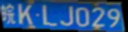

In [45]:
real_img = torchvision.transforms.ToPILImage()(img)
real_img

# Compute metrics

CER = (S + D + I) / N = (S + D + I) / (S + D + C)

where

S is the number of substitutions, D is the number of deletions, I is the number of insertions, C is the number of correct characters, N is the number of characters in the reference (N=S+D+C).

In [46]:
from evaluate import load
cer = load("cer")

In [47]:
references = dataset_test.text

In [48]:
predictions = []
for imgs, enc_text, text in dataloader_test:
    predictions += predict(imgs, model, tokenizer, device)

In [49]:
cer.compute(predictions=predictions, references=references)

0.0058005800580058

CER’s output is not always a number between 0 and 1, in particular when there is a high number of insertions. This value is often associated to the percentage of characters that were incorrectly predicted. The lower the value, the better the performance of the ASR system with a CER of 0 being a perfect score.

In [50]:
len(references) == len(predictions)

True

In [51]:
errors = {} # dict of errors {predictions: references}
for pred, refer in zip(predictions, references):
    if cer.compute(predictions=[pred], references=[refer]) != 0.0:
        errors[pred] = refer

In [52]:
errors

{'皖HL108D': '皖NL108D',
 '皖AE0082': '皖AF888S',
 '皖AN5R29': '冀AN5R29',
 '皖AE8F76': '皖AF8F76',
 '冀JS2363': '川JS2363',
 '皖A06Z16': '皖AD6Z16',
 '皖AL1D76': '皖AL1D70',
 '豫ADL439': '甘ADL439',
 '皖AZZ2D8': '皖AZZ208',
 '鄂E6V671': '赣E6V671',
 '鲁CKB654': '粤CKB654',
 '赣E269JY': '湘E269JY',
 '鄂AN08Q3': '豫AN08Q3',
 '皖SC716': '皖SCC716',
 '皖AB9017': '皖AP901T',
 '皖AH1179': '皖AH1178',
 '皖AHA18C': '皖AHA180',
 '鄂A607MG': '黑A607MG',
 '皖A9C714': '皖ADX714',
 '苏N71031': '沪N71031',
 '闽BB1188': '鄂BB1188',
 '皖A75156': '皖A751S6',
 '皖A280D5': '皖A28G05',
 '皖AL13DD': '皖AL130D',
 '皖AZW563': '皖AZW063',
 '皖AC38DM': '皖AC380M',
 '浙GLQ029': '津GLQ029',
 '皖E659B8': '赣E659B8',
 '冀FMK521': '鄂FMK521',
 '皖AG3327': '皖A03327',
 '皖AEDN66': '皖AE0N66',
 '皖APX498': '皖ADX498',
 '浙CN060V': '闽CN060V',
 '皖AN866G': '皖AN866B',
 '京Q6099K': '鲁Q6099K',
 '苏E160C0': '苏E16GL0',
 '苏A68R93': '苏A68RX3',
 '皖A050C0': '皖A05000',
 '皖MQE698': '皖NQE698',
 '京NRB208': '鲁NRB208',
 '皖EXX665': '陕EXX665',
 '晋BQA986': '鲁BQA986',
 '皖NBB293': '粤NBB293',
 '皖DR22P': '

As we can see, the model is most wrong on Chinese characters, I tried to fix it with augmentations, but still there are numbers on which the model is wrong. These errors most likely arise due to poor image quality, this can also be corrected by expanding the sample, or training the model specifically for recognizing Chinese characters and then merging it with the main model.
Also, the model sometimes makes mistakes in the length of the number and in the middle characters. This can be fixed with the help of augmentations: for example, painting over some part of a certain symbol. 

In [53]:
key_err_0 = list(errors.values())[0]

In [54]:
ind_err_0 = dataset_test.text.index(key_err_0)

Errors can also be due to damage to numbers, which we see in this example

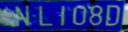

In [55]:
torchvision.transforms.ToPILImage()(dataset_test[ind_err_0][0])

In [56]:
list(errors.keys())[0]

'皖HL108D'

In [57]:
key_err_0 

'皖NL108D'

In [58]:
acc_avg = val_loop(dataloader_test, model, tokenizer, device)

Validation, acc: 0.9667


In [59]:
acc_avg

0.9666966696669667

Totals by metrics:

Accuracy on test: 0.9666966696669667

CER on test: 0.0058005800580058